# Stacked Denoising autoencoder
Trying the reproduce the results from (http://jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)
    
    Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion

The big issue for me is that I am not able to reproduce the filters the authors obtain: 
- They get blob/edge detectors
- I get some random crap

*Requirements*:
- lasagne
- nolearn

In [1]:
import numpy as np
import scipy.io
from lasagne.layers import get_output, InputLayer, DenseLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, linear
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
from nolearn.lasagne import visualize
from nolearn.lasagne import visualize
from nolearn.lasagne.visualize import plot_loss
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load the data from Olshausen, create 12x12 patches
data used in section 5.1, "natural images"

In [2]:
#download the data
import urllib.request
import os
if not os.path.exists("Olshausen.mat"):
    urllib.request.urlretrieve ("http://redwood.berkeley.edu/bruno/sparsenet/IMAGES.mat", "Olshausen.mat")

In [3]:
theImages = scipy.io.loadmat('Olshausen.mat')['IMAGES']

def get_random_patch(images, patchsize=12):
    """extracts a single random patch from the 3d matrix of images with shape: (x, y, samples)"""
    q,_, N = images.shape
    r = np.random.randint(N)
    x, y =  np.random.randint(q-patchsize,  size=(2,)) # q-N to stay within the image

    return images[x:x+patchsize,y:y+patchsize, r]

patchSize= 12
sampleSize = 50000
X = np.stack([get_random_patch(theImages,patchSize) for i in range(sampleSize)], axis=0)
X_out = X.reshape((X.shape[0], -1)) # flatten to compare vs last layer

# Experiment 1: linear undercomplete coder/decoder, no noise added
section 5.1 in their paper

In [4]:
"""first experiment: a linear encoder/decoder, squared loss"""
import theano
from lasagne.init import GlorotUniform

encode_size = 50

# to get tied weights in the encoder/decoder, create this shared weightMatrix
sharedWeights = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #

layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': rectify, 'W': sharedWeights }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights.T}),
]

ae1 = NeuralNet(
    layers=layers,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.05,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [5]:
ae1.fit(X, X_out);

# Neural Network with 7394 learnable parameters

## Layer information

  #  name     size
---  -------  ------
  0  input0   12x12
  1  encoder  50
  2  decoder  144

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.05417       0.04189      1.29327  0.71s
      2       0.03330       0.02593      1.28428  0.46s
      3       0.02187       0.01832      1.19397  0.45s
      4       0.01641       0.01460      1.12452  0.42s
      5       0.01370       0.01273      1.07691  0.41s
      6       0.01230       0.01173      1.04889  0.42s
      7       0.01151       0.01114      1.03321  0.41s
      8       0.01103       0.01077      1.02456  0.43s
      9       0.01071       0.01051      1.01945  0.42s
     10       0.01049       0.01032      1.01615  0.43s
     11       0.01032       0.01018      1.01393  0.41s
     12       0.01019       0.01007      1.01235  0.41s
     13       0.01009       0.00998      1.01120  0

In [6]:
plot_loss(ae1)
plt.ylim([0.008, 0.010])

(0.008, 0.01)

## inspect the reconstruction

In [7]:
from plottingUtils import tile_raster_images
%matplotlib inline

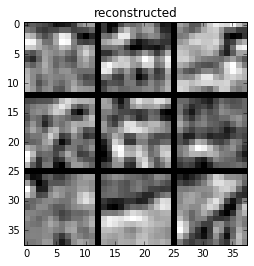

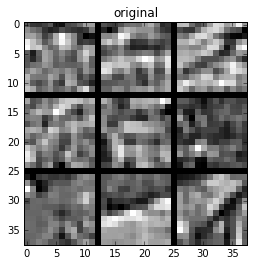

In [8]:
X_pred = ae1.predict(X)
tile_raster_images(X_pred[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1))
title('reconstructed')
tile_raster_images(X_out[0:9,:], (patchSize,patchSize), (3,3), tile_spacing=(1,1));
title('original');

## inspect the learned filters

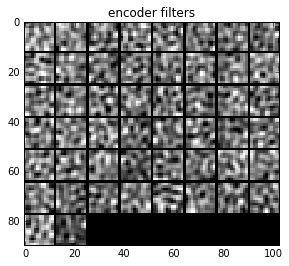

In [9]:
W_encode = ae1.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (7,8), tile_spacing=(1,1)); title('encoder filters')

doesnt really look like the "blob detectors" in Figure 5 middle

# Experiment 2: overcomplete AE with Gaussian noise
actually, we're supposed to add Gaussian noise each epoch, but thats kind of complicated right now.

Hence, I corrupt the images once in the beginning

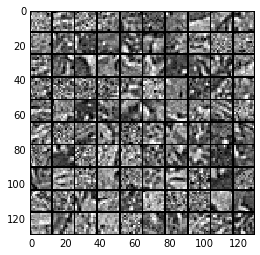

In [10]:
#corrupt the data with gaussian noise
sigma = 0.1
X_corrupted = X + np.random.normal(0,sigma, X.shape)
tile_raster_images(X_corrupted[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1));

In [11]:
encode_size = 200

#again, tied weights in the en/decoder
sharedWeights2 = theano.shared(GlorotUniform().sample(shape=(X.shape[1]**2, encode_size))) #
layers2 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2])}),
    (DenseLayer, {'name': 'encoder', 'num_units': encode_size, 'nonlinearity': rectify, 'W': sharedWeights2 }),
    (DenseLayer, {'name': 'decoder','num_units': patchSize**2, 'nonlinearity': linear, 'W': sharedWeights2.T}),
]

ae2 = NeuralNet(
    layers=layers2,
    max_epochs=100,
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    regression=True,
    verbose=1
)

In [12]:
ae2.fit(X_corrupted, X_out);

# Neural Network with 29144 learnable parameters

## Layer information

  #  name     size
---  -------  ------
  0  input0   12x12
  1  encoder  200
  2  decoder  144

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.04217       0.03522      1.19728  1.34s
      2       0.03221       0.02902      1.11017  1.05s
      3       0.02700       0.02489      1.08467  1.06s
      4       0.02358       0.02218      1.06312  1.10s
      5       0.02129       0.02031      1.04817  1.33s
      6       0.01968       0.01896      1.03808  1.11s
      7       0.01849       0.01793      1.03106  1.11s
      8       0.01757       0.01712      1.02597  1.09s
      9       0.01683       0.01646      1.02214  1.05s
     10       0.01622       0.01591      1.01920  1.23s
     11       0.01569       0.01543      1.01689  1.32s
     12       0.01524       0.01501      1.01504  1.10s
     13       0.01484       0.01464      1.01351 

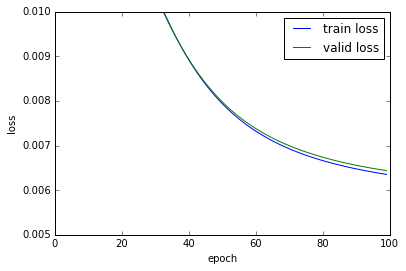

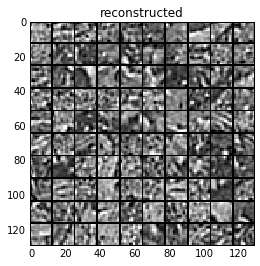

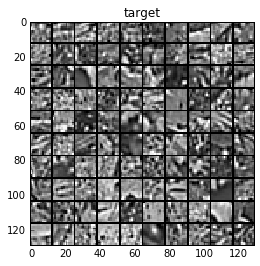

In [13]:
plot_loss(ae2);ylim([0.005,0.01])

# predictions
X_pred = ae2.predict(X_corrupted)
tile_raster_images(X_pred[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('reconstructed')
tile_raster_images(X_out[0:100,:], (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('target')

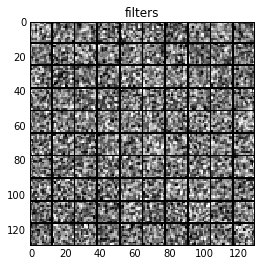

In [14]:
#filters
W_encode = ae2.layers_['encoder'].W.get_value()
tile_raster_images(W_encode.T, (patchSize,patchSize), (10,10), tile_spacing=(1,1)); title('filters');

VERY different from the edge detectors in Figure 6